In [1]:
import os
import re
import glob
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
%matplotlib inline

In [4]:
import umap

In [ ]:
# import hypertools as hyp

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
author = ["Chang_et_al", "Tse_et_al"][0]
task = ["Naming", "LD"][0]
data_folder = os.path.join("Output_Linguistic", author, task)

mdl = ["CSR", "GLM"][0]
zscored = ["", " (z-scored)"][0]
normed = ["", " (normed)"][1]

subj = ["", " (sub-5102"][1]
seed = ["", "_6180)"][1]

data_name = f"{mdl}_regression_results{zscored}{normed}{subj}{seed}.csv"
print(data_name)

CSR_regression_results (normed) (sub-5102_6180).csv


In [7]:
data_path = os.path.join(data_folder, data_name)
data = pd.read_csv(data_path)
print(data.columns)

Index(['SID', 'X0', 'LogCF', 'NS', 'CON', 'PC', 'SC', 'SAR', 'IMG', 'AoA',
       'F1^2', 'F2^2', 'F3^2', 'F4^2', 'F5^2', 'F6^2', 'F7^2', 'F8^2', 'F1F2',
       'F1F3', 'F1F4', 'F1F5', 'F1F6', 'F1F7', 'F1F8', 'F2F3', 'F2F4', 'F2F5',
       'F2F6', 'F2F7', 'F2F8', 'F3F4', 'F3F5', 'F3F6', 'F3F7', 'F3F8', 'F4F5',
       'F4F6', 'F4F7', 'F4F8', 'F5F6', 'F5F7', 'F5F8', 'F6F7', 'F6F8', 'F7F8',
       'R_squared', 'Adjusted_R2', 'LogLik', 'AIC', 'AICc', 'BIC', 'NRMSE'],
      dtype='object')


## Discriptive statistics (table)

In [ ]:
rawdata_folder = os.path.join("Data_Linguistic", author, task)
fn_regex = "zscored_sub_*.xlsx" if zscored == " (z-scored)" else "sub_*.xlsx"
data_paths = glob.glob(os.path.join(rawdata_folder, fn_regex))

if 'SID' in data.columns:
    data.set_index('SID', inplace=True)
data["nT"] = np.nan

for fp in data_paths:
    sid = int(re.findall('([\d]*).xlsx', os.path.basename(fp))[0])
    rawdata = pd.read_excel(fp)
    data.loc[sid, 'nT'] = len(rawdata)

In [ ]:
desc_cols = [
'X0', 'LogCF', 'NS', 'CON', 'PC', 'SC', 'SAR', 'IMG', 'AoA',
'R_squared', 'Adjusted_R2', 'LogLik', 'AIC', 'AICc', 'BIC', 'NRMSE', 'nT'
]

data_desc = (data[desc_cols].describe()
             .astype('float')
             .map(lambda x: f"{x:.3f}")
             .loc[['min', 'max', 'mean', 'std'], :]
             .T)
    
print(data_desc)

In [ ]:
dn = data_name.replace(".csv", "")
fp = os.path.join(data_folder, f"[Desc] {dn}.xlsx")

if not os.path.exists(fp):
    data_desc.to_excel(fp)

# Figures

In [ ]:
fig_folder = os.path.join("Figs_Linguistic", author, task)
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder) 

## Histogram chart

In [ ]:
for targ_col, bin_range in zip([
     'R_squared', 'Adjusted_R2', 'NRMSE', 'AIC', 'AICc', 'BIC', 
    'nT'
], [
    (0, .52), (-.1, .32), (.25, 871), (147, 565), (147, 565), (147, 565), 
    (100, 200)
]):
    if targ_col == 'nT':
        fn = f"[histplot] {targ_col}.png"
    else:
        fn = f"[histplot] {mdl} fitting {targ_col}.png"

    if not os.path.exists(os.path.join(fig_folder, fn)):
        sns.histplot(
            data=data, 
            x=targ_col, 
            binrange=bin_range, 
            kde=True, 
            bins=30
        )
        plt.axvline(
            data[targ_col].mean(), color="red", linestyle="-", 
        )
        plt.axvline(
            data[targ_col].median(), color="lightgreen", linestyle="-", 
        )
        plt.tight_layout() 
        plt.savefig(os.path.join(fig_folder, fn), format='png', dpi=200)
        plt.close()

## Overlapping density plots

In [ ]:
dn = data_name.replace(".csv", "")
fn = f"[coef] {dn}.png"

x_labels = ['X0', 'LogCF', 'NS', 'CON', 'PC', 'SC', 'SAR', 'IMG', 'AoA']

long_data = (data
             .loc[:, ['SID'] + x_labels]
             .melt(id_vars="SID"))

sorted_x_labs = sorted(x_labels, 
                       key=lambda x: 
                       data.loc[:, x_labels].mean().rank(ascending=False)[x])

colors = sns.cubehelix_palette(9, rot=-.25, light=.7)
sns.set_theme(style="white")

## Create ridgeplots in Matplotlib
## see: https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/

gs = grid_spec.GridSpec(len(x_labels), 1)
fig = plt.figure(figsize=(10, 6), dpi=200)

ax_objs = []
for i, xlab in enumerate(sorted_x_labs):
    ax_objs.append(fig.add_subplot(gs[i:i+1, :]))
    
    plot = (long_data
            .query("variable == @xlab")["value"]
            .plot.kde(ax=ax_objs[-1], lw=0.5))
    
    # grabbing x and y data from the kde plot
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    
    # filling the space beneath the distribution
    ax_objs[-1].fill_between(x, y, color=colors[i])

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.8, 1.1) # min(long_data["value"]), max(long_data["value"])
    ax_objs[-1].set_ylim(0, 8.5) # print(max(y))

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove axis ticks and labels 
    ax_objs[-1].set_ylabel('')
    ax_objs[-1].set_yticklabels([])
    if xlab != sorted_x_labs[-1]:
        ax_objs[-1].set_xticklabels([])
    
    # remove borders
    for s in ["top", "right", "left", "bottom"]:
        ax_objs[-1].spines[s].set_visible(False)
        
    # add labels
    ax_objs[-1].text(-0.8, # min(long_data["value"])
                     0.5, xlab, 
                     fontweight="bold", fontsize=14, ha="right")
    
    # mark median, mean, and zero
    ax_objs[-1].axvline(
        data[xlab].median(), color="lightgreen", linestyle="-"
    )
    ax_objs[-1].axvline(
        data[xlab].mean(), color="red", linestyle="--"
    )
    ax_objs[-1].axvline(
        0, color="black", linestyle="-", lw=.5
    )

# overlapping axes objects
gs.update(hspace= -0.5)

# plt.show()
plt.savefig(os.path.join(fig_folder, fn), format='png', bbox_inches='tight')
plt.close()

print(f"saved: {fn}")

## Plot clustering

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [18]:
from sklearn.manifold import TSNE

In [9]:
coefs = data.iloc[:, 1:46]

In [ ]:
X_scaled = StandardScaler().fit_transform(coefs)

In [24]:
X_pca = PCA(
    n_components=2
).fit_transform(X_scaled)

In [25]:
X_umap = umap.UMAP(
    n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=-1
).fit_transform(X_scaled)

In [26]:
X_tsne = TSNE(
    n_components=2, perplexity=12, init='random', learning_rate='auto'
).fit_transform(X_scaled)

[]

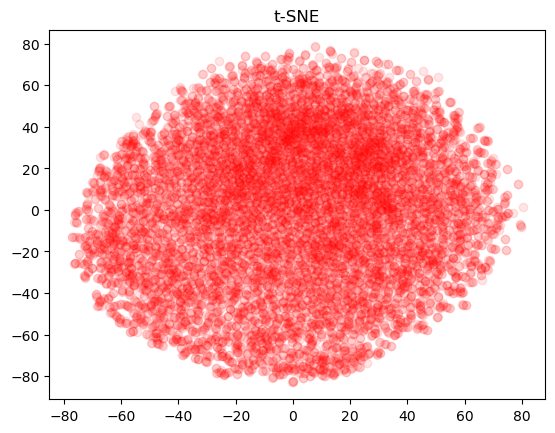

In [29]:
x = 2
X_reduced = [X_pca, X_umap, X_tsne][x]
plt.scatter(
    X_reduced[:, 0], X_reduced[:, 1], 
    c='r', # cmap='coolwarm', 
    alpha=0.1
)
plt.title(["PCA", "UMAP", "t-SNE"][x])
plt.plot()